<a href="https://colab.research.google.com/github/evgeny-kolonsky/Lab3_MW/blob/main/Lab3_MW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Lab 3  Mechanical Waves

Evgeny Kolonsky 2024

v.0.1.10 Q=12 (vs 120), high absorbtion

In [40]:
import numpy as np
from scipy import linalg as LA
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

#Intro

![overview](https://raw.githubusercontent.com/evgeny-kolonsky/Lab3_MW/refs/heads/main/mech_waves_overview.png)


## Natural freqiencies

Motion equataion for a system of $n$ chained osciallators with viscous friction in matrix form is
$$
M \ddot x + B \dot x + K x = 0
$$
here $M$ - moment inertia matrix, $B$ - friction coefficients matrix, $K$ - angle elastity matrix, $x$ - coordinates (rotation angles) vector.

Coordinates vector $x$
$$
x =  \begin{bmatrix}
      x_1 \\
      \vdots\\
      x_n \end{bmatrix} ,
$$

Inertia matrix $M$
$$
M =  \begin{bmatrix}
      J_1 &     \\
       &\ddots & \\
       &            & J_n
      \end{bmatrix} ,
$$
Friction matrix $B$
$$
B =  \begin{bmatrix}
      b_1 &     \\
       &\ddots & \\
       &            & b_n
      \end{bmatrix} ,
$$
Elastity matrix $K$
$$
K =  \begin{bmatrix}
      2 k &  -k  &  &         \\
      -k  &  2k  & -k &          \\
         & -k   & 2k  & -k &         \\
      & & &\ddots & -k\\
      & &         & -k & 2 k
      \end{bmatrix}
$$

If $E_i$ is eigenvectors  matrix and $\lambda_i$  are eigenvalues of matrix $Z = M^{-1}  K$, then natural frequecnies $\omega_i$ of the system are respective square roots of eigenvalues:
$$
\omega_i^2 = \lambda_i \quad i = 1,\cdots, n.
$$



In [41]:
# System parameters
# wide unit
l = 456e-3  # length of a bar
m = 43e-3   # mass of a bar
J = m * l**2 / 12 # moment of inertia of a bar
n = 72  # number of bars in the oscillation system

k = 1.02 # elastity coeff

K = k * np.diag(np.ones(n) * 2, 0) + \
    np.diag(-np.ones(n-1)   , 1) +  \
    np.diag(-np.ones(n-1)   ,-1)

M = np.eye(n) * J




Q = 12 # quality factor
b =  np.sqrt(J*k) / Q # approx. friction coefficent (at least by order value)

B = np.eye(n) * b



Km  =  LA.inv(M) @ K
Bm  =  LA.inv(M) @ B

lambdas, E = LA.eig(Km)
omega = np.sqrt(lambdas)

freqs = np.real(omega) / 2 / np.pi

print(f'Natural frequencies from {np.min(freqs):.2f} Hz to {np.max(freqs):.2f} Hz')

Natural frequencies from 1.19 Hz to 11.72 Hz



**Numerical solution**

We set up new **state variable** $z$:
$$
z =  [ x_1, \cdots x_n, \, \dot x_1, \cdots, \dot x_n ] = [x, \dot x]
$$
and it's derivative
$$
\dot z =  [ \dot x, \ddot x ].
$$

The motion equation becomes state equation:
$$
\dot z =
\begin{bmatrix}
\dot x\\
\ddot x
\end{bmatrix}
 =
\begin{bmatrix}
0 & 1\\
-M^{-1}K & 0
\end{bmatrix}
\begin{bmatrix}
x\\
\dot x
\end{bmatrix}
$$
for no-friction no-forces case. Here $0$ and $1$ are zero and identity matricies respectively.

The state equation with viscous friction and external forces will be
$$
\dot z =
\begin{bmatrix}
0 & 1\\
-M^{-1}K & -M^{-1}B
\end{bmatrix}
z
+
\begin{bmatrix}
0 \\
M^{-1} F
\end{bmatrix}
\tag{1}
$$

State equation (1) enables iterative numerical solution by [Heun method](https://en.wikipedia.org/wiki/Heun%27s_method).


In [42]:
zeros = np.zeros((n,n))
I     = np.eye(n)

D = np.vstack([np.hstack([zeros,  I]),
               np.hstack([-Km,   -Bm])] \
             )
F = np.zeros(n)
F2 = np.hstack([np.zeros(n), F])


def state_derivative(state, time):
  # state - array of x1 .. xn, v1.. vn
  # x - coordinates and v - corresponding velocities
  # ti - point of time. External force depends on time
  zdot = D @ state
  F2[n] = k * eta(time) / J  # applied only at leftmost point
  zdot += F2
  return zdot

def heun_step(state, time, dt,etol=0.000001,maxiters = 100):
    '''Update a state to the next time increment using the implicit Heun's method.

    Arguments
    ---------
    state : array of dependent variables
    dt    : float, time increment
    etol  : tolerance in error for each time step corrector
    maxiters: maximum number of iterations each time step can take

    Returns
    -------
    next_state : array, updated after one time increment'''
    e = 1
    eps = np.finfo('float64').eps
    next_state = state + state_derivative(state, time) * dt
    ################### New iterative correction #########################
    for n in range(0, maxiters):
        next_state_old = next_state
        next_state = state + (state_derivative(state, time) + state_derivative(next_state, time))/2*dt
        e = np.sum(np.abs(next_state-next_state_old) / np.abs(next_state+eps))
        if e < etol:
            break
    ############### end of iterative correction #########################
    return next_state


## Waves propagation


wave propagation constant
$$
\beta =  \sqrt{\frac{k}{J}}
$$

In [43]:
# the mechanical wave system
L = 920e-3 # length of the system
d = 1.27e-2  # m,distance between bars

beta = np.sqrt(k/J)
v = d * beta

print(f'wave velocity expected {v*100:.0f} cm/s, {beta:.0f} bar/s')



wave velocity expected 47 cm/s, 37 bar/s


# Integrate numerically

Define external force profile

In [44]:
# External harmonic force
order = 11 # harmonic order
freq_external = order * v /  4 / L # Hz, displacement frequency
eta0 = 1.0 # radian    displacement amplitude
print(f'external force frequency {freq_external:.2f} Hz')

# initial beat at the right end
eta = lambda t: np.sin(2*np.pi*freq_external*t) * eta0 # if t < 1/freq_external/8 else 0


external force frequency 1.40 Hz


Define time scope

In [45]:
T = 4 * L / v # time to travel there and back again twice
dt = 1 / np.max(freqs) / 4 # shortest period / 4


t = np.arange(0, T, dt)
N = len(t)  # steps in time

Integrate numerically

In [46]:
state = np.zeros((2 * n, N))

for i in range(0, N-1):
    state[:,i+1] = heun_step(state[:,i], t[i], dt)

print(f'Integrate for {N} steps {T:.1f} s')

Integrate for 368 steps 7.8 s


Animate

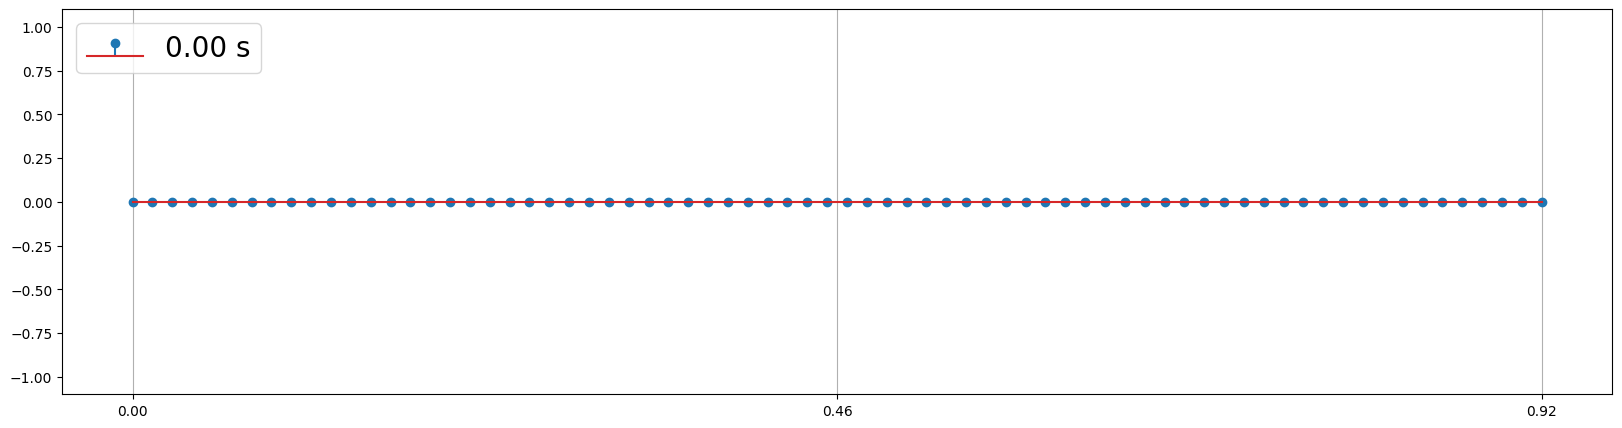

In [39]:
fig, ax = plt.subplots(figsize=(20, 5))
x = np.linspace(0, L, n)
y = np.copy(state[:n, 0])
y[0] = 1.0 * eta0 # vertical scale
y[-1] = - y[0]
bottom = 0
h_stem = ax.stem(x, y, bottom=bottom,  linefmt='-', markerfmt='o', label='Time');
legend = ax.legend(fontsize="20", loc ="upper left") #Define legend objects
ax.grid(axis='x')
ax.set_xticks([0, L/2, L])

def update(i):
    y = state[:n, i]

    # markerline
    h_stem[0].set_ydata(y)
    #h_stem[0].set_xdata(x)  # not necessary for constant x

    # stemlines
    h_stem[1].set_paths([np.array([[xx, bottom],
                                   [xx, yy]]) for (xx, yy) in zip(x, y)])

    # baseline
    h_stem[2].set_xdata([np.min(x), np.max(x)])
    #h_stem[2].set_ydata([bottom, bottom])  # not necessary for constant bottom
    legend.get_texts()[0].set_text(f'{t[i]:.2f} s') #Update label each at frame

anim = FuncAnimation(fig, update, frames=range(0, N,1), interval=1*dt)
anim.save('so.gif', dpi=80)

**References**

Charles G. Torre
Department of Physics, Utah State University
04 Linear Chain of Coupled Oscillators [.pdf](https://digitalcommons.usu.edu/foundation_wave/19/)


Computational Mechanics 5 - Good Vibrations [.ipynb](https://cooperrc.github.io/computational-mechanics/module_05/03_Good_Vibrations.html#./02_Keep_it_steady.ipynb)